## Explore what causes delivery delays 

In [1]:
import pandas as pd

# Load the data 
df_orders = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.fact_orders', project_id='project-brazilian-ecommerce')
df_order_items = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.dim_order_items', project_id='project-brazilian-ecommerce')
df_payments = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.dim_payments', project_id='project-brazilian-ecommerce')
df_customers = pd.read_gbq('SELECT * FROM project-brazilian-ecommerce.ecommerce_data.dim_customers', project_id='project-brazilian-ecommerce')

C:\Users\anjal\anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2518: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\Users\anjal\anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2532: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
C:\Users\anjal\anaconda3\lib\site-packages\google\cloud\bigquery\table.py:2546: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [39]:
# Convert the datetime columns to datetime dtype
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], errors='coerce')
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders['order_delivered_customer_date'], errors='coerce')

# Calculate the delivery time in days
df_orders['delivery_time_days'] = (df_orders['order_delivered_customer_date'] - df_orders['order_purchase_timestamp']).dt.days

# Handle NaN values in 'delivery_time_days' by filling them with a default value 
df_orders['delivery_time_days'] = df_orders['delivery_time_days'].fillna(0).astype(int)

In [40]:
df = pd.merge(df_orders, df_order_items[['order_id', 'price', 'freight_value', 'product_category_name_english']], on='order_id', how='left')
df = pd.merge(df, df_payments[['order_id', 'payment_type']], on='order_id', how='left')
df = pd.merge(df, df_customers[['customer_id', 'customer_city', 'customer_state']], on='customer_id', how='left')

In [41]:
df['order_month'] = df['order_purchase_timestamp'].dt.month

In [8]:
#df = pd.get_dummies(df, columns=['payment_type', 'customer_city', 'customer_state'], drop_first=True)


## Insights on correlation between delivery time and price, freight value, total price, payment type

In [9]:
df = pd.get_dummies(df, columns=['payment_type'], drop_first=True)
# Compute correlation matrix for numerical columns
correlation_matrix = df.corr()

# Display correlation with 'delivery_time_days'
correlation_with_delivery_time = correlation_matrix['delivery_time_days'].sort_values(ascending=False)
print(correlation_with_delivery_time)

delivery_time_days          1.000000
freight_value               0.201417
total_order_value           0.056452
price                       0.054286
payment_type_voucher        0.002429
payment_type_debit_card    -0.021793
payment_type_credit_card   -0.038953
order_month                -0.052159
Name: delivery_time_days, dtype: float64


#### Freight Value: The correlation is 0.201417, suggesting a positive relationship between freight costs and delivery time. Orders with higher freight values might take slightly longer to deliver.

## Insights on correlation between delivery time and customer states

In [42]:
df_state = pd.get_dummies(df, columns=['customer_state'], drop_first=True)
# Compute correlation matrix for numerical columns
correlation_matrix = df_state.corr()

# Display correlation with 'delivery_time_days'
correlation_with_delivery_time = correlation_matrix['delivery_time_days'].sort_values(ascending=False)
#print(correlation_with_delivery_time)

# Filter only the columns for customer states (those starting with 'customer_state_')
state_columns = [col for col in correlation_with_delivery_time.index if col.startswith('customer_state_')]

# Extract correlations for customer states only
state_correlations = correlation_with_delivery_time[state_columns]

# Sort the correlations in descending order
sorted_state_correlations = state_correlations.sort_values(ascending=False)

# Display the sorted correlations for states
#print(sorted_state_correlations)

# Get top 10 states with the highest correlation
top_10_states_highest = state_correlations.sort_values(ascending=False).head(10)

# Get top 10 states with the lowest correlation
top_10_states_lowest = state_correlations.sort_values(ascending=True).head(10)

# Display results
print("Top 10 States with Highest Correlation:")
print(top_10_states_highest)


Top 10 States with Highest Correlation:
customer_state_BA    0.127292
customer_state_PA    0.112645
customer_state_RJ    0.104589
customer_state_CE    0.096113
customer_state_MA    0.078974
customer_state_AL    0.075429
customer_state_PE    0.073309
customer_state_RS    0.068532
customer_state_PB    0.061065
customer_state_AM    0.056265
Name: delivery_time_days, dtype: float64


#### Bahia (BA) (0.127292): Orders to Bahia have the highest positive correlation with delivery time, indicating that deliveries to this state tend to take longer. Pará (PA) (0.112645) and Rio de Janeiro (RJ) (0.104589) also show relatively strong positive correlations, suggesting extended delivery times compared to other states.

In [43]:
print("\nTop 10 States with Lowest Correlation:")
print(top_10_states_lowest)



Top 10 States with Lowest Correlation:
customer_state_SP   -0.328215
customer_state_MG   -0.016921
customer_state_PR   -0.010241
customer_state_DF    0.006923
customer_state_TO    0.026327
customer_state_MS    0.028128
customer_state_RR    0.028405
customer_state_RO    0.037036
customer_state_GO    0.042954
customer_state_AP    0.043739
Name: delivery_time_days, dtype: float64


#### São Paulo stands out with a notable negative correlation, indicating significantly shorter delivery times compared to other states. This may reflect better infrastructure or proximity to distribution centers.

## Insights on correlation between delivery time and product categories

In [35]:
# Filter product category columns only
product_category_columns = [col for col in correlation_with_delivery_time.index if col.startswith('product_category_name_english')]

# Extract correlations for product categories
product_category_correlations = correlation_with_delivery_time[product_category_columns]

# Sort correlations in descending order
sorted_product_category_correlations = product_category_correlations.sort_values(ascending=False)

# Display the correlations
#print(sorted_product_category_correlations)

# Display the top 10 product categories with the highest correlations
top_10_categories = product_category_correlations.sort_values(ascending=False).head(10)
print(top_10_categories)



product_category_name_english_office_furniture         0.109970
product_category_name_english_garden_tools             0.025244
product_category_name_english_computers_accessories    0.021086
product_category_name_english_fashion_shoes            0.013979
product_category_name_english_bed_bath_table           0.013758
product_category_name_english_christmas_supplies       0.012325
product_category_name_english_furniture_living_room    0.010839
product_category_name_english_furniture_decor          0.010794
product_category_name_english_consoles_games           0.008461
product_category_name_english_electronics              0.008421
Name: delivery_time_days, dtype: float64


#### Office furniture has the strongest positive correlation with delivery time, suggesting that orders for this category might tend to experience longer delivery times. Garden tools show a slight positive correlation, indicating slightly longer delivery times for orders in this category.

In [33]:
# Display the bottom 10 product categories with the lowest correlations
bottom_10_categories = product_category_correlations.sort_values(ascending=True).head(10)
print(bottom_10_categories)


product_category_name_english_housewares                        -0.040705
product_category_name_english_food                              -0.019931
product_category_name_english_fashion_bags_accessories          -0.017383
product_category_name_english_luggage_accessories               -0.016943
product_category_name_english_construction_tools_construction   -0.016173
product_category_name_english_toys                              -0.015579
product_category_name_english_pet_shop                          -0.015326
product_category_name_english_health_beauty                     -0.014889
product_category_name_english_construction_tools_lights         -0.014455
product_category_name_english_drinks                            -0.013759
Name: delivery_time_days, dtype: float64


#### Housewares have the strongest negative correlation, suggesting that orders for this category may experience slightly faster delivery times compared to others. Food-related orders are also somewhat negatively correlated, implying shorter delivery times.

## Insights on correlation between delivery time and months

In [15]:
# Group by 'order_month' and calculate the mean delivery time for each month
monthly_delivery_mean = df.groupby('order_month')['delivery_time_days'].mean()

# Display the mean delivery time for each month
print(monthly_delivery_mean)


order_month
1     13.169843
2     15.275641
3     14.330064
4     11.453401
5     10.674566
6      9.537105
7      9.254375
8      8.379829
9     11.340580
10    11.422450
11    14.194987
12    14.541660
Name: delivery_time_days, dtype: float64


#### February (Month 2) has the longest average delivery time at 15.28 days. Other months with long average delivery times include March (14.33 days), November (14.19 days), and December (14.54 days), likely reflecting possible delays due to seasonal or logistical factors (e.g., holidays).

#### August (Month 8) shows the shortest average delivery time at 8.38 days. July and June also have relatively short delivery times at 9.25 days and 9.54 days, respectively.


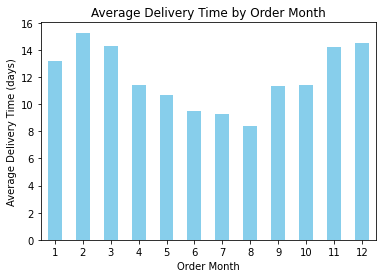

In [16]:
import matplotlib.pyplot as plt

# Plot a bar chart for mean delivery times by month
monthly_delivery_mean.plot(kind='bar', color='skyblue')
plt.title('Average Delivery Time by Order Month')
plt.xlabel('Order Month')
plt.ylabel('Average Delivery Time (days)')
plt.xticks(rotation=0)  # Keep month labels horizontal
plt.show()


## Delivery Time Analysis Overview
#### There’s a positive relationship between freight value and delivery time. Orders with higher freight costs tend to take slightly longer to deliver, reflecting the complexity or handling requirements of higher-value shipments.

#### States like Bahia, Pará, and Rio de Janeiro, primarily in the north and northeast, likely face logistical challenges such as accessibility, infrastructure, or proximity to warehouses. São Paulo stands out with significantly shorter delivery times due to better infrastructure and proximity to major distribution centers.

#### Office furniture shows the strongest positive correlation, suggesting that orders in this category might take longer due to size or shipping requirements. Housewares have the strongest negative correlation, indicating faster deliveries, possibly due to easier stock availability or simpler shipping logistics. Food-related orders also show a minor negative correlation, suggesting quicker deliveries. 

#### February has the longest average delivery time, followed by March, November, and December. Seasonal peaks, holidays, and higher demand likely contribute to these delays.